Тестовое задание для кандидатов на вакансию Quantitative Analyst / Data scientist <br>
Алексей Северин

## Подключение библиотек и Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import seaborn as sb
from sklearn.metrics import confusion_matrix


file = pd.read_csv("QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv")
ticker_names = ["China","SP500","Note"]
file["Ticker"] = [ticker_names[0] if i == "FTSE CHINA A50 INDEX FUTURES" else ticker_names[1] if i == 'E-MINI S&P 500 FUTURES' else ticker_names[2] for i in file["Ticker Full Name"]]

In [2]:
file.head()

,Timestamp,Close Candle,Ticker Full Name,Ticker
0,2020-01-01 18:01:00,128.312,10 YEAR TREASURY NOTE FUTURES,Note
1,2020-01-01 18:02:00,128.312,10 YEAR TREASURY NOTE FUTURES,Note
2,2020-01-01 18:03:00,128.312,10 YEAR TREASURY NOTE FUTURES,Note
3,2020-01-01 18:04:00,128.312,10 YEAR TREASURY NOTE FUTURES,Note
4,2020-01-01 18:05:00,128.328,10 YEAR TREASURY NOTE FUTURES,Note


## Предпроцессинг данных


### Преобразование изначальную таблицы

Для удобства дальнейшей работы необходимо преобразовать начальную таблицу к виду, где напротив каждого времени стоят значения цен для трех инструментов <br>

Шаги преобразования: <br>

1) Находим уникальные даты и сортируем их <br>

2) Создаем новую таблицу с индексами равными уникальным датам <br>

3) Переносим записи из изначальной таблицы в созданную,где цены распределены по колонкам инструментов <br>

In [3]:
#1
unique_data = sorted(np.unique(file["Timestamp"]))
concat_data = pd.DataFrame()
concat_data["Time"] = unique_data
for i in range(len(ticker_names)):
    concat_data[ticker_names[i]] = [0 for i in range(len(unique_data))]

#2
concat_data.index = concat_data["Time"]

#3
#Следующая операция занимает 3 минуты. Не самое быстрое решение, возможно есть способ это сделать быстрее
for i in tqdm(range(len(file))):
    date = file.loc[i,"Timestamp"]
    ticker = file.loc[i,"Ticker"]
    price = file.loc[i,"Close Candle"]
   # print(date,ticker,price)
    concat_data.loc[date, ticker] = price
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1756857/1756857 [02:41<00:00, 10904.35it/s]


In [4]:
concat_data.head()

,Time,China,SP500,Note
Time,,,,
2020-01-01 18:01:00,2020-01-01 18:01:00,0.0,3236.25,128.312
2020-01-01 18:02:00,2020-01-01 18:02:00,0.0,3234.75,128.312
2020-01-01 18:03:00,2020-01-01 18:03:00,0.0,3235.25,128.312
2020-01-01 18:04:00,2020-01-01 18:04:00,0.0,3236.00,128.312
2020-01-01 18:05:00,2020-01-01 18:05:00,0.0,3235.50,128.328


In [5]:
concat_data.tail()

,Time,China,SP500,Note
Time,,,,
2021-11-30 23:55:00,2021-11-30 23:55:00,15390.0,4605.75,0.0
2021-11-30 23:56:00,2021-11-30 23:56:00,15390.0,4606.75,0.0
2021-11-30 23:57:00,2021-11-30 23:57:00,15388.0,4606.50,0.0
2021-11-30 23:58:00,2021-11-30 23:58:00,15390.0,4606.50,0.0
2021-11-30 23:59:00,2021-11-30 23:59:00,15393.0,4606.50,0.0


### Трансформация ценовых данных

Работая с временными рядами цен, я предпочитаю использовать разность логарифмов цены с ее лаговым значением, по сути использую процентное изменение цены в сравнении с предыдущим моментом 

Данная мера позволяет решить несколько проблем: <br>

1) Проблема гетероскедастичности. <br>Данный вопрос часто возникает во временных рядах, так как со временем волатильность инструментов повышается и соответственно некоторые модели начинают давать неэффективную оценку. 

2) Отсутствие стационарности. <br>Разница логарифмов позволяет привести данные к стационарному виду. Это необходимое требование для большинства временных статистических моделей, а так же это упрощает поиск зависимостей внутри данных. <br>

3) Вопрос (проблема слишком сильное в данном контексте) масштаба. <br>Использование абсолютных значений цен нескольких инструментов усложняет работу с моделью и может давать плохие результаты. Так например, рост S&P500 на 5 тиков не дает интуитивного понимания насколько должен измениться индекс Шанхайской фондовой биржи. Относительные изменения позволяют улучшить интепретируемость модели. 

Однако, перед тем как трансформировать данные необходимо решить как решать проблему пропущенных значений. 

#### Количество пропущенных значений

In [6]:
number_of_missed = 0
for i in ticker_names:
    number_of_missed += len(concat_data[concat_data[i] == 0.0])
    

print(number_of_missed, " - количество пропущенных значений")
print(round(number_of_missed * 100 / 3 / len(concat_data.iloc[:,0])), " - процент пропущенных значений")

296451  - количество пропущенных значений
14  - процент пропущенных значений


#### Возможные методы

Я рассматривал четыре возможных варианта: <br>

1) Выкинуть ряды в которых есть пропущенные значения <br>

2) Так как инструментов три я могу изучать пары и в данном случае для каждой пары придется меньше данных выкидывать используя первый способ <br>

3) Можно использовать заполнение цен вперед, то есть если для инструмента нет данных во время t, то заполнить это время первой  ближайшей доступной ценой в прошлом. <br>Однако данный способ может привнести достаточно много шума учитывая небольшую размерность наших данных <br>

4) *Также можно использовать заполненение пропущенных значений используя модели прогнозирования, но данный способ считаю не подходящим для текущей задачи

#### Исследование пропущенных значений

При более внимательном изучении таблицы я обнаружил, как и предпологал изначально, периоды в которых цены инструмента пропущены чаще, чем в другое время <br>
Это могут быть технические перерывы биржи или же закрытие биржи на ночь <br>
Именно такие ряды я и решил выкинуть

Для этих целей добавим колонку Time_HMS, время в часах/минутах/секундах и колонку missed_value, если хотя бы один инструмент содержит пропущенные данные <br> После найдем время суток, для которого отсутствие данных свойственно

In [7]:
concat_data["Time_HMS"] = concat_data["Time"].str[-8:]
concat_data["missed_value"] = [1 for i in range(len(concat_data))]

for i in ticker_names:
    concat_data["missed_value"] = concat_data["missed_value"] * concat_data[i]

# -1, если данных нет и 0, если есть
concat_data["missed_value"] = [-1 if i <= 0 else 0 for i in concat_data["missed_value"]]

In [8]:
missed_values_distribution = pd.DataFrame(concat_data.groupby(["Time_HMS"]).sum()["missed_value"])

In [9]:
missed_values_distribution.head()

,missed_value
Time_HMS,
00:00:00,-181
00:01:00,-185
00:02:00,-183
00:03:00,-187
00:04:00,-205


Общее количество дней в таблице

In [10]:
number_of_days = len(np.unique(concat_data["Time"].str[:10]))
print(number_of_days)

599


Добавим колонку с процентом пропущенных рядов от общего количества рядов с данным внутридневным временем

In [11]:
missed_values_distribution["%_missed_value"] = round(100 * missed_values_distribution["missed_value"] * -1 / number_of_days)

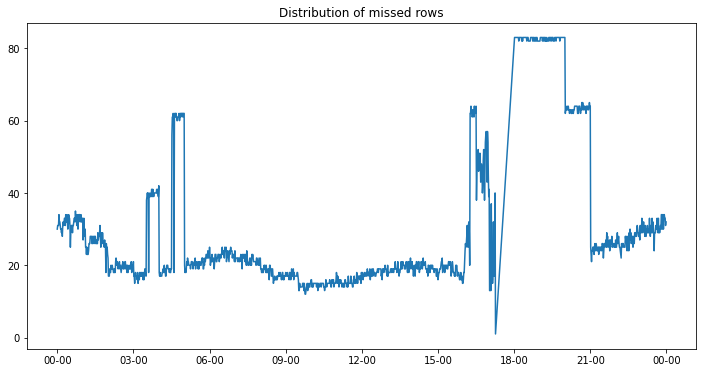

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.to_datetime(missed_values_distribution.index, format='%H:%M:%S'),missed_values_distribution["%_missed_value"])

date_form = DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(date_form)
plt.title("Distribution of missed rows")
plt.show()

#### Выбранный отрезок

Для дальнейшего анализа был взят отрезок от 6 утра до 15 дня. <br>
Я понимаю, что выкидываю из данных открытие американской биржи и прочие вероятно важные времена <br> 
Однако, я хочу сфокусироваться на хорошем изучении одного отрезка и выбранный отрезок представляется мне наиболее интересным ввиду наибольшей полноты данных (малого процента пропущенных значений)

In [13]:
reduce_concat = concat_data[(concat_data["Time_HMS"] >= "06:00:00") & (concat_data["Time_HMS"] <= "15:00:00")]
reduce_concat

,Time,China,SP500,Note,Time_HMS,missed_value
Time,,,,,,
2020-01-02 06:00:00,2020-01-02 06:00:00,14605.0,3250.00,128.359,06:00:00,0
2020-01-02 06:01:00,2020-01-02 06:01:00,0.0,3250.00,128.359,06:01:00,-1
2020-01-02 06:02:00,2020-01-02 06:02:00,14600.0,3249.75,128.375,06:02:00,0
2020-01-02 06:03:00,2020-01-02 06:03:00,14600.0,3250.25,128.359,06:03:00,0
2020-01-02 06:04:00,2020-01-02 06:04:00,0.0,3250.25,128.359,06:04:00,-1
...,...,...,...,...,...,...
2021-11-30 14:56:00,2021-11-30 14:56:00,15353.0,4574.75,131.500,14:56:00,0
2021-11-30 14:57:00,2021-11-30 14:57:00,15352.0,4575.00,131.531,14:57:00,0
2021-11-30 14:58:00,2021-11-30 14:58:00,15356.0,4577.25,131.546,14:58:00,0


#### Финальная трансформация

Заполнение пропущенных значений предыдущими может быть неправильным, с точки зрения поставленной задачи <br>
В этом случае для таких значений будет естественно, если они будут высокоскореллированы с предыдущими данными для других инструментов

Поэтому дальнейшая трансформация для каждого инструмента i будет проведена следующим образом: <br>

1) Создаются лаговые значения времени суток и цен инструмента i <br>

2) Создается переменная i_Exist равная 1, если текущее значение и лаговые не отсутствуют, иначе 0 <br>

3) Если i_Exist равно 1, то берется разница логарифмов текущей и предыдущей цен, иначе 0 <br>

4) Из таблицы выкидывается наблюдения со значением в колонке Time_HMS равные 6 утра <br> Для исследования зависимостей только внутри дня, но не между

In [14]:
shifted = pd.DataFrame()
shifted['Time_HMS'] = reduce_concat["Time_HMS"][1:].values
shifted['Time_HMS-1'] = reduce_concat["Time_HMS"][0:-1].values
for i in tqdm(ticker_names):
    shifted[i] = reduce_concat[i][1:].values
    shifted[i + '-1'] = reduce_concat[i][0:-1].values
    shifted[i + '_Exist'] = [1 if i > 0 else 0 for i in shifted[i] * shifted[i + '-1']]
    shifted[i + '_Delta'] = [np.log(shifted.loc[j,i]) - np.log(shifted.loc[j,i + '-1']) if shifted.loc[j,i + '_Exist'] > 0 else 0 for j in range(len(shifted))]
    
shifted = shifted[shifted["Time_HMS"] != '06:00:00']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.80s/it]


In [15]:
shifted.head()

,Time_HMS,Time_HMS-1,China,China-1,China_Exist,China_Delta,SP500,SP500-1,SP500_Exist,SP500_Delta,Note,Note-1,Note_Exist,Note_Delta
0,06:01:00,06:00:00,0.0,14605.0,0,0.0,3250.00,3250.00,1,0.000000,128.359,128.359,1,0.000000
1,06:02:00,06:01:00,14600.0,0.0,0,0.0,3249.75,3250.00,1,-0.000077,128.375,128.359,1,0.000125
2,06:03:00,06:02:00,14600.0,14600.0,1,0.0,3250.25,3249.75,1,0.000154,128.359,128.375,1,-0.000125
3,06:04:00,06:03:00,0.0,14600.0,0,0.0,3250.25,3250.25,1,0.000000,128.359,128.359,1,0.000000
4,06:05:00,06:04:00,14600.0,0.0,0,0.0,3249.75,3250.25,1,-0.000154,128.359,128.359,1,0.000000


In [16]:
shifted.tail()

,Time_HMS,Time_HMS-1,China,China-1,China_Exist,China_Delta,SP500,SP500-1,SP500_Exist,SP500_Delta,Note,Note-1,Note_Exist,Note_Delta
267321,14:56:00,14:55:00,15353.0,15354.0,1,-0.000065,4574.75,4575.00,1,-0.000055,131.500,131.500,1,0.000000
267322,14:57:00,14:56:00,15352.0,15353.0,1,-0.000065,4575.00,4574.75,1,0.000055,131.531,131.500,1,0.000236
267323,14:58:00,14:57:00,15356.0,15352.0,1,0.000261,4577.25,4575.00,1,0.000492,131.546,131.531,1,0.000114
267324,14:59:00,14:58:00,15358.0,15356.0,1,0.000130,4577.00,4577.25,1,-0.000055,131.546,131.546,1,0.000000
267325,15:00:00,14:59:00,15363.0,15358.0,1,0.000326,4577.25,4577.00,1,0.000055,131.562,131.546,1,0.000122


Из всех колонок нас интресуют только Time_HMS и колонки Delta <br>
Остальные колонки были вспомогательные и для дальнейшего анализа не нужны

In [17]:
data = pd.DataFrame()
data["Time"] = shifted["Time_HMS"]
for i in ticker_names:
    data[i + "_Delta"] = shifted[i + "_Delta"]

In [18]:
data.head()

,Time,China_Delta,SP500_Delta,Note_Delta
0,06:01:00,0.0,0.000000,0.000000
1,06:02:00,0.0,-0.000077,0.000125
2,06:03:00,0.0,0.000154,-0.000125
3,06:04:00,0.0,0.000000,0.000000
4,06:05:00,0.0,-0.000154,0.000000


In [19]:
data.tail()

,Time,China_Delta,SP500_Delta,Note_Delta
267321,14:56:00,-0.000065,-0.000055,0.000000
267322,14:57:00,-0.000065,0.000055,0.000236
267323,14:58:00,0.000261,0.000492,0.000114
267324,14:59:00,0.000130,-0.000055,0.000000
267325,15:00:00,0.000326,0.000055,0.000122


## Анализ лаговых зависимостей

Создадим копию полученной таблицы (сугубо вспомогательная операция)

In [20]:
data_copy = data.copy()

### Создание лаговых значений для каждого инструмента

В исследовании будут использоваться 10 лаговых значений

In [21]:
data_ = pd.DataFrame()
number_of_lags = 10
for j in ticker_names:
    for i in range(0,number_of_lags + 1):
        data_[j + "_"+str(i)] = data_copy.loc[:,j + "_Delta"].shift(i, fill_value = 0)

data_

,China_0,China_1,China_2,China_3,China_4,China_5,China_6,China_7,China_8,China_9,...,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,Note_7,Note_8,Note_9,Note_10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000125,0.000125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000125,0.000125,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267321,-0.000065,0.000261,0.000065,-0.000130,0.000456,0.000196,-0.000782,-0.000391,0.000130,0.000195,...,-0.000114,0.000000,0.000000,-0.000357,0.000000,0.000000,0.000000,0.000000,0.0,-0.000122
267322,-0.000065,-0.000065,0.000261,0.000065,-0.000130,0.000456,0.000196,-0.000782,-0.000391,0.000130,...,0.000000,-0.000114,0.000000,0.000000,-0.000357,0.000000,0.000000,0.000000,0.0,0.000000
267323,0.000261,-0.000065,-0.000065,0.000261,0.000065,-0.000130,0.000456,0.000196,-0.000782,-0.000391,...,0.000236,0.000000,-0.000114,0.000000,0.000000,-0.000357,0.000000,0.000000,0.0,0.000000
267324,0.000130,0.000261,-0.000065,-0.000065,0.000261,0.000065,-0.000130,0.000456,0.000196,-0.000782,...,0.000114,0.000236,0.000000,-0.000114,0.000000,0.000000,-0.000357,0.000000,0.0,0.000000


### Тренировочная/Тестовая выборка

Разделим данные на train/test в соотношении 70/30 <br>
Тестовые данные будут необходимы для проверки полученных зависимостей

In [22]:
train = data_.iloc[:round(len(data) * 0.7),:]
test = data_.iloc[round(len(data) * 0.7):,:]

### Матрица корреляций

Чтобы не перегружать диаграмму выведем только корреляции текущих значений и 3 предыдущих лагов для всех инструментов <br> <br>
К сожалению, матрица корреляций не содержит информации, подтверждающей возможную лаговую зависимость между инструментами

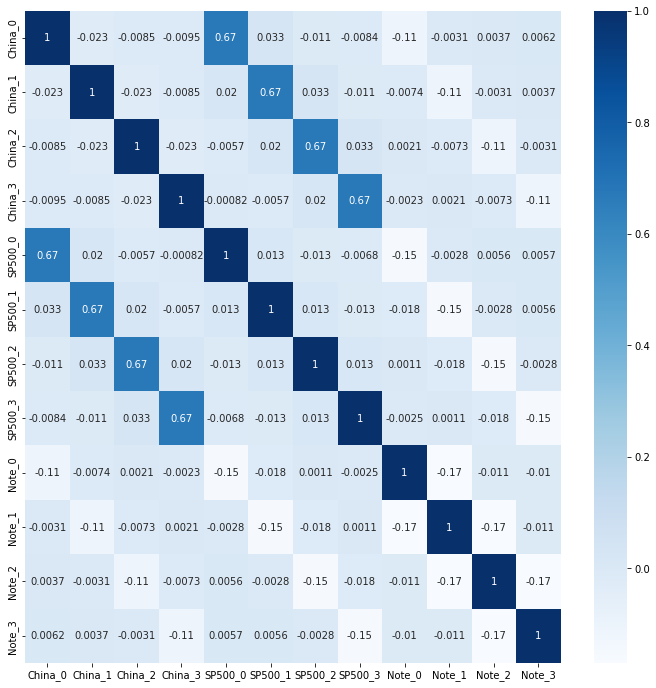

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
cols = []
for i in ticker_names:
    for j  in range(0,4):
        cols.append(i + "_" +  str(j))
corr = train.loc[:,cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)
plt.show()

### Distributed Lag Model

В качестве модели для поиска лаговой зависимости использовалась классическая линейная регрессия
Это не самый точный метод, однако она отлично подходит для создания базовой модели и не требует дополнительной настройки параметров

In [24]:
import statsmodels.formula.api as smf
# Создаем массив, куда будут сохраняться модели
models = []
for i in ticker_names:
    # Задаем формулу регрессии
    formula = i + "_0 ~ 1 + "
    for t in ticker_names:
        for j in range(1,number_of_lags + 1):
            if t != i:
                # Например, для China формула будет выглядеть:
                # China_0 = 1 + SP500_1 + SP500_2 + ... + Note_10
                formula += "+" + t + "_" + str(j) + " "
    
    model = smf.ols(formula = formula, data = train)
    model = model.fit()
    # Записываем полученную модель в массив
    models.append(model)

#### Регрессия для Шанхая

Несмотря на то, что R-squared совсем незначительный, коэффициенты S&P500 выглядят статистически значимыми <br>
Могу предположить, что используя S&P500 можно улучшить прогноз Шанхайского индекса, в то время как облигации почти не имеют смысла

In [25]:
print(models[0].summary())

                            OLS Regression Results                            
Dep. Variable:                China_0   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     16.99
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           6.35e-60
Time:                        20:08:57   Log-Likelihood:             1.2420e+06
No. Observations:              186781   AIC:                        -2.484e+06
Df Residuals:                  186760   BIC:                        -2.484e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.073e-06   7.25e-07      1.479      0.1

#### Регрессия для S&P500

Есть пару значимых коэффициентов, однако модель выглядит намного слабее в сравнении с предыдущей <br>
Поэтому данная модель не будет использоваться для дальнейшего анализа и фокус будет направлен на исследование зависимости Шанхая от Америки

In [26]:
print(models[1].summary())

                            OLS Regression Results                            
Dep. Variable:                SP500_0   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.201
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           1.64e-28
Time:                        20:08:57   Log-Likelihood:             1.1332e+06
No. Observations:              186781   AIC:                        -2.266e+06
Df Residuals:                  186760   BIC:                        -2.266e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.453e-06    1.3e-06      1.119      0.2

#### Регрессия для Note

Почти все коэффициенты незначимые за исключением ближайших лаговых <br>
Нет оснований полагать, что облигации зависят от лаговых значений индексов, за исключением ближайших лагов


In [27]:
print(models[2].summary())

                            OLS Regression Results                            
Dep. Variable:                 Note_0   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.138
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           4.07e-13
Time:                        20:08:57   Log-Likelihood:             1.4486e+06
No. Observations:              186781   AIC:                        -2.897e+06
Df Residuals:                  186760   BIC:                        -2.897e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.237e-07    2.4e-07     -0.516      0.6

#### Сокращенная модель для Шанхая

Выбросим из первой регрессии незначимые лаговые значения облигаций и intercept, так как они вероятнее всего не улучшают качество предсказаний

В новой модели все коэффициенты модели значимы, хотя R^2 до сих пор не очень высок

In [28]:
formula = "China" + "_0 ~ 0 "

for j in range(1,number_of_lags + 1):
    formula += "+" + "SP500" + "_" + str(j) + " "

    
model_regr = smf.ols(formula = formula, data = train)
model_regr = model_regr.fit()

print(model_regr.summary())

                                 OLS Regression Results                                
Dep. Variable:                China_0   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              32.99
Date:                Sat, 12 Mar 2022   Prob (F-statistic):                    8.48e-65
Time:                        20:08:57   Log-Likelihood:                      1.2420e+06
No. Observations:              186781   AIC:                                 -2.484e+06
Df Residuals:                  186771   BIC:                                 -2.484e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Тестирование

### Прогноз

Большинство торговых моделей ставит перед собой цели предсказания размера изменений цены, а не направление изменения <br>
Причина этого проста: 9 правильных прогнозов могут легко перекрыться одной убыточной сделкой <br>

Однако, в качестве метрики для исследования существования лаговой зависимости я буду использовать точность предсказания изменения цены <br>
Такая метрика более чем подходит для установления существования связи, но для разработки торговой системы лучше было бы использовать метрики прибыли, максимальной просадки и прочие подобные метрики


Для оценки лаговой зависимости использовался следующий алгоритм: <br>

1) Сделать прогноз зависимой переменной(China_0) на тестовой выборке  <br>

2) Найти индексы фактического значения зависимой переменной ind_, для которых она не равна 0 <br>

3) Для ненулевых значений зависимой переменной определить направление их изменений y_true_dir: 0, если меньше 0; 1, если больше 0<br>

4) Выбрать прогнозы с индексами равными ind_ и определить направление их изменений y_pred_dir: 0, если меньше 0; 1, если больше 0<br>

5) Использовать y_true_dir и y_pred_dir для высчитывания метрик

In [29]:
# Функция получения направления для ненулевых фактических значений и соответствующих прогнозов
def categorization_non_zero(y_true, y_pred):
    
    y_true_non_zero = [1 if i > 0 else 0 for i in y_true[y_true != 0]]
    y_pred_non_zero = [1 if i > 0 else 0 for i in y_pred[y_true != 0]]

    
    return y_true_non_zero, y_pred_non_zero

In [30]:
# Функция для отрисовки confusion matrix в процентах
def confuse_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)/ len(y_pred)
    ax = sb.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.2%')

    ax.set_title('Confusion matrix for Direction');
    ax.set_xlabel('Predicted Direction')
    ax.set_ylabel('Actual Direction');

    ax.xaxis.set_ticklabels(['Fall', "Growth"])
    ax.yaxis.set_ticklabels(['Fall', "Growth"])
    
    plt.show()

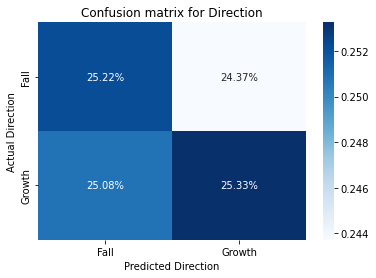

In [31]:
y_true_dir, y_pred_dir = categorization_non_zero(test["China_0"], model_regr.predict(test))
confuse_matrix(y_true_dir, y_pred_dir)

In [32]:
print("Количество ненулевых фактических значений -",len(y_true_dir))

Количество ненулевых фактических значений - 60303


Как можно увидеть из confusion matrix модель не дает огромных значений accuracy или precision <br>
Данный результат ожидаем, если вспомнить R^2 равный всего лишь 0.002 <br>
Иными словами, модель помогает объяснить 0.2% колебаний цен <br>
Однако, модель лучше чем наугад определяет фазы роста 50.2%(25.33 vs 25.08) и еще лучше фазы падения 50.8%(25.22 vs 24.37)

### Проверка статистической значимости результата

Проверим статистическую значимость результатов нашей модели <br>
В качестве метрики будет использоваться классическая точность <br> 

Поскольку наша модель не делает перекос прогнозов в отношении какого-либо класса, то я считаю что для проверки значимости результата мы можем предпологать, что случайное гадание между ростом и падением дало бы нам точность в 50% <br>

Данную оговорку я делаю, так как в случае если бы наша модель всегда предсказывала рост, то ее точность на этих данных составлила 50.4%, однако данный результат был бы получен благодаря небольшому дисбалансу между классами <br>

Тестирование гипотезы о пропорции:

$$ H_0: p = 0.5 $$
$$ H_a: p > 0.5 $$

$$ z-stat = \frac{\hat{p} - p}{\sqrt{\frac{p*q}{n}}} = \frac{0.5055 - 0.5}{\sqrt{\frac{0.5*0.5}{60303}}} = 2.7$$



$$ P-value = P(z-stat < Z) = P(2.7 < Z) = 1 - Ф(2.7) = 0.0034$$

Таким образом, нулевая гипотеза отвергается <br>
И существуют статистически значимые доказательства того, что точность предсказания модели выше случайного гадания

## Заключение

В исследовании самой большой сложностью была обработка начальных данных, так как они содержали большое количество пропущенных значений <br>
Для решения этой проблемы использовалась дифференциация логарифмов временных рядов <br>
А также использовались был выбран участок времени с 6 утра до 15 дня как равномерный участок с наименьшим процентом пропущенных данных 

Для проверки существования лаговой зависимости между инструментами использовалась линейная регрессия

В результате исследования я пришел к выводу, что существует лаговая зависимость Шанхайского индекса от Американского фондового рынка <br>
Хотя найденная зависимость не может объяснить большую часть изменений цен, однако она имеет статистически значимый эффект <br>

Вероятно, можно улучшить модель для предсказания Шанхайского индекса путем добавления лаговых Шанхайских значений, но в поставленной задаче необходимо было исследовать зависимость между различными инструментами <br>

## Направления для дальнейшей работы

Дальнейшая работа может вестись в следующих направлениях: <br>

1) Использовать для анализа всю временную кривую, а не только время с 6 до 15 <br>

2) Использовать более продвинутые инструменты прогнозирования: различные модели бустинга и нейронные сети (CNN) <br>

3) Расширить количество доступных инструментов 


P.S. Я очень старался при выполнении тестового задания и в некоторых моментах использовал не самые распространенные и очевидные решения <br>
Поэтому я бы очень услышать критику о релевантности такого решения
